In [1]:
import os
import json
import pandas as pd
import numpy as np
from PIL import Image, ImageDraw
from pprint import pprint
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def batch_iou(boxes, box):
    lr = np.maximum(
        np.minimum(boxes[:, 2], box[2]) - np.maximum(boxes[:, 0], box[0]),
        0.
    )
    tb = np.maximum(
        np.minimum(boxes[:, 3], box[3]) - np.maximum(boxes[:, 1], box[1]),
        0.
    )
    inter = lr * tb
    union = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1]) +\
            (box[2] - box[0]) * (box[3] - box[1]) - inter
    return inter.astype(np.float32) / union


def nms_custom(boxes, conf, iou_thresh, box_avg_type='mean'):
    conf = np.array(conf)
    boxes = np.array(boxes)
    
    order = conf.argsort()[::-1]
    boxes_ord = boxes[order]
    conf_ord = conf[order]

    num_boxes = boxes.shape[0]
    fin_boxes = []
    fin_conf = []
    boxes_left = boxes_ord
    conf_left = conf_ord
    while boxes_left.shape[0] > 1:
        ovps = batch_iou(boxes_left[1:], boxes_left[0])
        mask = ovps > iou_thresh

        boxes_group = [boxes_left[0].reshape(1,4)]
        conf_group = [conf_left[0]]
        has_group = mask.sum() > 0
        if has_group:
            boxes_group.append(boxes_left[1:][mask].reshape(-1,4))
            conf_group.extend(conf_left[1:][mask])
        boxes_group = np.concatenate(boxes_group, axis=0)
        conf_group = np.array(conf_group)

        if box_avg_type == 'conf':
            box_weights = conf_group / conf_group.sum()
            box_avg = (boxes_group * box_weights[:,np.newaxis]).sum(axis=0)
        elif box_avg_type == 'conf_pow':
            box_weights = conf_group ** 4
            box_weights /= box_weights.sum()
            box_avg = (boxes_group * box_weights[:,np.newaxis]).sum(axis=0)
        elif box_avg_type == 'mean':
            box_avg = boxes_group.mean(axis=0)
        else:
            raise ValueError
        conf_avg = conf_group.max()
        fin_boxes.append(box_avg.reshape(1,4))
        fin_conf.append(conf_avg)

        keep = np.bitwise_not(mask)
        conf_left = conf_left[1:][keep]
        boxes_left = boxes_left[1:][keep]

    if boxes_left.shape[0] == 1:
        fin_boxes.append(boxes_left[0].reshape(1,4))
        fin_conf.append(conf_left[0])

    fin_boxes = np.round(np.concatenate(fin_boxes, axis=0)).astype(np.int32)
    fin_conf = np.array(fin_conf)
    return fin_boxes, fin_conf

In [3]:
image_dir = 'data/hack2/hack2_test/'

In [4]:
classes = ["lamp", "armchair", "dining_table", "shelf", "desk", "bed", "couch", "chair", "wardrobe"]
cls_colors = [
    (255,255,255),
    (255,255,0),
    (255,0,255),
    (255,0,0),
    (0,255,255),
    (0,255,0),
    (0,0,255),
    (255,255,127),
    (255,127,255)
]
cls_colors = {cls:cls_colors[i] for i,cls in enumerate(classes)}
print(cls_colors)

def to_fmt(cls_pred, width, height, conf_thresh, draw=None):
    bbox_list = []
    conf_list = []
    for pol, prob in cls_pred:
        if prob < conf_thresh:
            continue
        bbox = np.array(pol)
        bbox[:, 0] *= width
        bbox[:, 1] *= height
        bbox = bbox.astype(int)
        xmin, ymin = bbox.min(axis=0)
        xmax, ymax = bbox.max(axis=0)
        if draw is not None: draw.rectangle((xmin,ymin,xmax,ymax))
        bbox_list.append([xmin,ymin,xmax,ymax])
        conf_list.append(prob)
    return bbox_list, conf_list

{'shelf': (255, 0, 0), 'armchair': (255, 255, 0), 'dining_table': (255, 0, 255), 'bed': (0, 255, 0), 'couch': (0, 0, 255), 'lamp': (255, 255, 255), 'desk': (0, 255, 255), 'wardrobe': (255, 127, 255), 'chair': (255, 255, 127)}


In [5]:
# mask_rcnn_furniture_0015.h5 0.3 0.0548779649829
# attempt1/furniture20180317T0042/last.h5 говно
# attempt2/furniture20180317T0042/mask_rcnn_furniture_0005.h5 0.3 0.0540255155264
# attempt3/furniture20180317T0042/mask_rcnn_furniture_0010.h5 0.33 0.0552196712923 
# attempt3/furniture20180317T0042/mask_rcnn_furniture_0012.h5 0.33 0.0553565741127 $$
# attempt3/furniture20180317T0042/mask_rcnn_furniture_0000.h5 0.5 0.0564432810419  $$
# attempt3/furniture20180317T0042/mask_rcnn_furniture_0004.h5 0.3 0.0548174821948
# attempt3/furniture20180317T0042/mask_rcnn_furniture_0005.h5 0.59 0.0565719091788 | 0.35 0.0564128826338 $$
# attempt3/furniture20180317T0042/mask_rcnn_furniture_0007.h5 0.34 0.0547277807084
# attempt3/furniture20180317T0042/mask_rcnn_furniture_0002.h5 0.4 0.0543842989756
# attempt3/furniture20180317T0042/mask_rcnn_furniture_0014.h5 0.3 0.0547633140958
# attempt4/furniture20180317T0042/mask_rcnn_furniture_0000.h5 0.43 0.0561559031887
# attempt4/furniture20180317T0042/mask_rcnn_furniture_0001.h5 0.41 0.0576388339552
# attempt4/furniture20180317T0042/mask_rcnn_furniture_0002.h5

In [6]:
grp_dir='hackathon/submissions/group_2/'
input_submis = []
input_names = []
for name in os.listdir(grp_dir):
    print(name)
    input_names.append(name)
    input_submis.append(pd.read_csv(grp_dir+name))

mask_rcnn_furniture_0012_raw.csv
mask_rcnn_furniture_0003_attempt4_raw.csv
mask_rcnn_furniture_0001_attempt4_raw.csv
mask_rcnn_furniture_0005_raw.csv
mask_rcnn_furniture_0000_raw.csv


In [7]:
input_submis[0].head()

,id,input,prediction
0,0,"{""image"": ""https://dbrain-public.s3.eu-west-1....","{""aabb"": {""lamp"": [], ""shelf"": [], ""couch"": []..."
1,1,"{""image"": ""https://dbrain-public.s3.eu-west-1....","{""aabb"": {""lamp"": [], ""shelf"": [[[[0.532552083..."
2,2,"{""image"": ""https://dbrain-public.s3.eu-west-1....","{""aabb"": {""lamp"": [], ""shelf"": [[[[0.391927083..."
3,3,"{""image"": ""https://dbrain-public.s3.eu-west-1....","{""aabb"": {""lamp"": [[[[0.5924479166666666, 0.10..."
4,4,"{""image"": ""https://dbrain-public.s3.eu-west-1....","{""aabb"": {""lamp"": [], ""shelf"": [], ""couch"": [[..."


In [8]:
input_submis[1].head()

,id,input,prediction
0,0,"{""image"": ""https://dbrain-public.s3.eu-west-1....","{""aabb"": {""lamp"": [], ""shelf"": [], ""couch"": []..."
1,1,"{""image"": ""https://dbrain-public.s3.eu-west-1....","{""aabb"": {""lamp"": [], ""shelf"": [[[[0.5390625, ..."
2,2,"{""image"": ""https://dbrain-public.s3.eu-west-1....","{""aabb"": {""lamp"": [], ""shelf"": [[[[0.662760416..."
3,3,"{""image"": ""https://dbrain-public.s3.eu-west-1....","{""aabb"": {""lamp"": [[[[0.5963541666666666, 0.07..."
4,4,"{""image"": ""https://dbrain-public.s3.eu-west-1....","{""aabb"": {""lamp"": [], ""shelf"": [[[[0.671875, 0..."


In [9]:
IOU_THRESH = 0.5
DRAW=False

CONF_THRESH = {
    'mask_rcnn_furniture_0012_raw.csv': 0.9,  # WORST
    'mask_rcnn_furniture_0001_attempt4_raw.csv':0.8,
    'mask_rcnn_furniture_0005_raw.csv':0.8,
    'mask_rcnn_furniture_0000_raw.csv':0.8,
    'mask_rcnn_furniture_0003_attempt4_raw.csv':0.8  # BEST
}

class_conf = {cls: [] for cls in classes}

ensemble_preds = {}  # image_id: aabb_dict
#for i in range(5):
for i in range(input_submis[0].shape[0]):
    img_name = '{:06d}.jpg'.format(int(input_submis[0].iloc[i,0]))
    img_path = image_dir + img_name
    im=Image.open(img_path)
    width, height = im.size
    #print(img_path)
    #print(width,height)
    
    if DRAW:im = np.array(im)
    
    nms_pred = {}
    for cls in classes:
        #print(cls)
        total_boxes = []
        total_conf = []
        for si in range(len(input_submis)):
            aabb=eval(input_submis[si].iloc[i,2])['aabb']
            bbox_1, conf_1 = to_fmt(aabb[cls], width, height, CONF_THRESH[input_names[si]])
            total_boxes.extend(bbox_1)
            total_conf.extend(conf_1)
        class_conf[cls].extend(total_conf)
        #print(total_boxes)
        #print(total_conf)
        nms_pred[cls] = []
        if total_boxes:
            nms_boxes, nms_conf = nms_custom(total_boxes,total_conf,IOU_THRESH,'conf')
            polys = []
            for left,top,right,bottom in nms_boxes:
                #print(cls_colors[cls])
                
                if DRAW:
                    cv2.rectangle(im,(left,top),(right,bottom),cls_colors[cls],2)
                    cv2.putText(im,cls,(left,top),cv2.FONT_HERSHEY_COMPLEX,1,(255,255,255))
                
                poly = np.array([
                    [left, top],
                    [left, bottom],
                    [right, bottom],
                    [right, top],
                    [left, top]
                ],dtype=float)
                poly[:,0] /= width
                poly[:,1] /= height
                polys.append(poly.tolist())
                
            nms_pred[cls] = polys
    #print(nms_pred)
    
    if DRAW:
        plt.figure(figsize=(12,8))
        plt.imshow(im)
        plt.axis('off')
    
    ensemble_preds[i]={'aabb': nms_pred}
#pprint(ensemble_preds)

In [10]:
for cls in classes:
    print(cls, np.mean(class_conf[cls]))

('lamp', 0.9396534837545822)
('armchair', 0.9411265424640775)
('dining_table', 0.9470006408396272)
('shelf', 0.9215616788420385)
('desk', 0.9348916638009327)
('bed', 0.9687450259923935)
('couch', 0.9672923635010704)
('chair', 0.9536797135504501)
('wardrobe', 0.934189495496469)


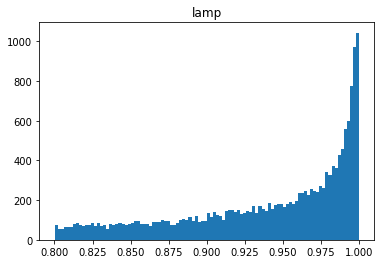

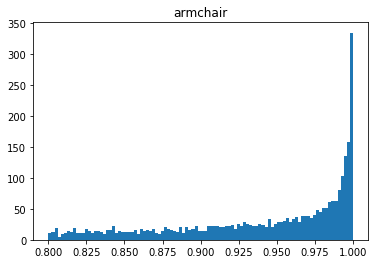

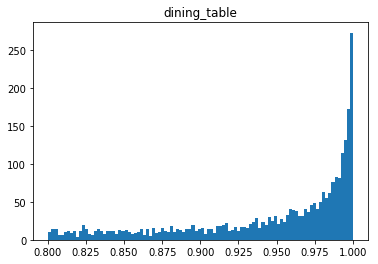

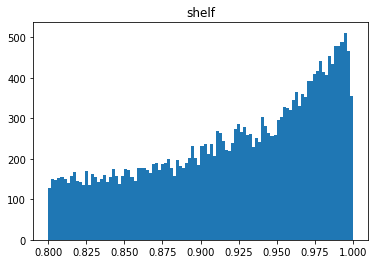

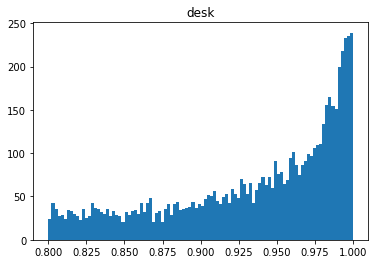

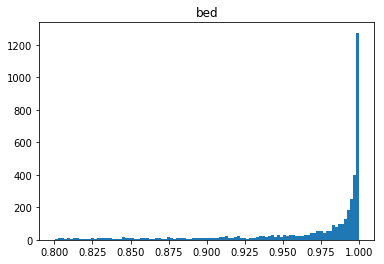

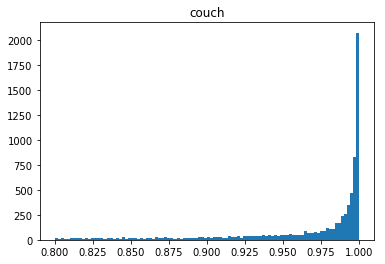

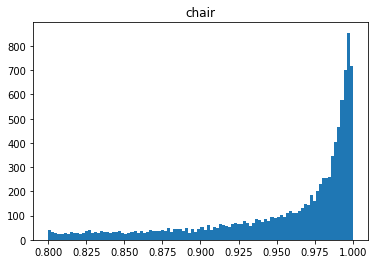

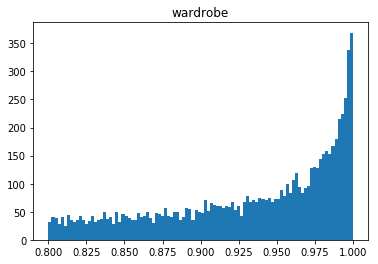

In [11]:
for cls in classes:
    plt.hist(class_conf[cls],100);
    plt.title(cls)
    plt.show()

In [12]:
out_df = input_submis[0].copy()
for i in range(out_df.shape[0]):
    out_df.iloc[i,2] = json.dumps(ensemble_preds[i])

In [13]:
suffix='2.3'
out_name='hackathon/submissions/ensemble_{}.csv'.format(suffix)
out_df.to_csv(out_name,index=None)

In [14]:
out_df=pd.read_csv(out_name)
out_df.head()

,id,input,prediction
0,0,"{""image"": ""https://dbrain-public.s3.eu-west-1....","{""aabb"": {""shelf"": [], ""armchair"": [], ""dining..."
1,1,"{""image"": ""https://dbrain-public.s3.eu-west-1....","{""aabb"": {""shelf"": [[[0.535, 0.265079365079365..."
2,2,"{""image"": ""https://dbrain-public.s3.eu-west-1....","{""aabb"": {""shelf"": [[[0.38958333333333334, 0.4..."
3,3,"{""image"": ""https://dbrain-public.s3.eu-west-1....","{""aabb"": {""shelf"": [[[0.6825, 0.58571428571428..."
4,4,"{""image"": ""https://dbrain-public.s3.eu-west-1....","{""aabb"": {""shelf"": [[[0.6675, 0.66444444444444..."


In [15]:
pprint(eval(out_df.iloc[1,2]))

{'aabb': {'armchair': [],
          'bed': [],
          'chair': [],
          'couch': [],
          'desk': [[[0.28583333333333333, 0.7952380952380952],
                    [0.28583333333333333, 1.0063492063492063],
                    [0.7658333333333334, 1.0063492063492063],
                    [0.7658333333333334, 0.7952380952380952],
                    [0.28583333333333333, 0.7952380952380952]]],
          'dining_table': [],
          'lamp': [],
          'shelf': [[[0.535, 0.2650793650793651],
                     [0.535, 0.346031746031746],
                     [0.715, 0.346031746031746],
                     [0.715, 0.2650793650793651],
                     [0.535, 0.2650793650793651]],
                    [[0.5391666666666667, 0.12063492063492064],
                     [0.5391666666666667, 0.19047619047619047],
                     [0.7291666666666666, 0.19047619047619047],
                     [0.7291666666666666, 0.12063492063492064],
                     [0.53916666666

In [16]:
pprint(eval(input_submis[0].iloc[1,2]))

{'aabb': {'armchair': [],
          'bed': [],
          'chair': [],
          'couch': [],
          'desk': [[[[0.2734375, 0.8184523809523809],
                     [0.2734375, 1.0168650793650793],
                     [0.76953125, 1.0168650793650793],
                     [0.76953125, 0.8184523809523809],
                     [0.2734375, 0.8184523809523809]],
                    0.9563313722610474]],
          'dining_table': [],
          'lamp': [],
          'shelf': [[[[0.5325520833333334, 0.26537698412698413],
                      [0.5325520833333334, 0.34970238095238093],
                      [0.7174479166666666, 0.34970238095238093],
                      [0.7174479166666666, 0.26537698412698413],
                      [0.5325520833333334, 0.26537698412698413]],
                     0.9983144998550415],
                    [[[0.5338541666666666, 0.12648809523809523],
                      [0.5338541666666666, 0.19345238095238096],
                      [0.7356770833333334,